# Which genes are turned on/off in some cancers but not others?

In [1]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [1]:
def dx_group(split, matched_tn, fc=1.):
    tab_1 = binomial_test_screen(matched_tn.ix[:, ti(split==True)], fc=fc)
    tab_1 = tab_1.ix[(((tab_1.frac - .5).abs() > .25) & (tab_1.p > .001)) == False]
    
    tab_0 = binomial_test_screen(matched_tn.ix[:, ti(split==False)], fc=fc)
    tab_0 = tab_0.ix[(((tab_0.frac - .5).abs() > .25) & (tab_0.p > .001)) == False]
    
    df = matched_tn.ix[:, ti(split==True)]
    ttest_1 = df.apply(ttest_rel, axis=1)
    
    df = matched_tn.ix[:, ti(split==False)]
    ttest_0 = df.apply(ttest_rel, axis=1)
    
    t0 = pd.concat([tab_0, ttest_0], keys=['binom','ttest'], axis=1)
    t1 = pd.concat([tab_1, ttest_1], keys=['binom','ttest'], axis=1)
    t = pd.concat([t0, t1], keys=['miss','hit'], axis=1)
    return t

def dx_group(split, matched_tn, fc=1.5):
    """
    Run a differential expression analysis on a cohort, splitting on a
    binary variable.  I.E. Do patients with TP53 mutations have differing
    patterns of differential expression that wild-types.
    """
    tab_1 = binomial_test_screen(matched_tn.ix[:, true_index(split == True)],
                                 fc=fc)
    tab_1 = tab_1.ix[(((tab_1.frac - .5).abs() > .25) & (tab_1.p > .01)) ==
                     False]

    tab_0 = binomial_test_screen(matched_tn.ix[:, true_index(split==False)],
                                 fc=fc)
    tab_0 = tab_0.ix[(((tab_0.frac - .5).abs() > .25) & (tab_0.p > .01)) ==
                     False]

    df = matched_tn.ix[:, true_index(split == True)]
    ttest_1 = df.apply(ttest_rel, axis=1)

    df = matched_tn.ix[:, true_index(split == False)]
    ttest_0 = df.apply(ttest_rel, axis=1)

    t0 = pd.concat([tab_0, ttest_0], keys=['binom', 'ttest'], axis=1)
    t1 = pd.concat([tab_1, ttest_1], keys=['binom', 'ttest'], axis=1)
    t = pd.concat([t0, t1], keys=['miss', 'hit'], axis=1)
    return t

In [3]:
vc = codes.ix[matched_rna.columns.get_level_values(0).unique()].value_counts()
vc.sum()

650

In [4]:
cancers = ti(vc > 40)

In [5]:
dx = {c: dx_group(codes==c, matched_tn) for c in cancers}
dx = pd.concat(dx, axis=1)
dx = dx.ix[dx_rna.index]

In [6]:
t_m = dx.xs(('miss','binom','frac'), axis=1, level=[1,2,3])
t_h = dx.xs(('hit','binom','frac'), axis=1, level=[1,2,3])
p = dx.xs(('miss','ttest','p'), axis=1, level=[1,2,3])
num_dx = dx.xs(('hit','binom','num_dx'), axis=1, level=[1,2,3])
t_m = t_m.mask(num_dx < 30)

In [7]:
mag_frac = lambda f: (f - .5).abs()

In [8]:
v = (mag_frac(t_m) - mag_frac(t_h)) * (p < .01)
v = v.stack().order()

In [9]:
tt = dx.xs(('hit','ttest','t'), axis=1, level=[1,2,3])
tt = tt.astype(float)

In [10]:
ttm = dx.xs(('miss','ttest','t'), axis=1, level=[1,2,3])
ttm = ttm.astype(float)

In [11]:
t_h.head()

,BRCA,COAD,HNSC,KIRC,LIHC,LUAD,LUSC,PRAD,THCA
?,0.37,0.78,0.22,0.40,0.74,0.61,0.52,0.38,0.37
A1BG,0.77,0.17,0.54,0.56,0.12,0.56,0.42,0.12,0.81
A1CF,0.39,0.05,0.44,0.56,0.22,0.67,0.62,0.57,0.50
A2BP1,0.29,0.12,0.25,0.06,0.58,0.55,0.59,0.13,0.53
A2LD1,0.47,0.59,0.39,0.18,0.36,0.79,0.66,0.81,0.66


In [12]:
import Figures.Regression as F
reload(F)


<module 'Figures.Regression' from '/cellar/users/agross/TCGA_Code/Figures/src/Figures/Regression.pyc'>

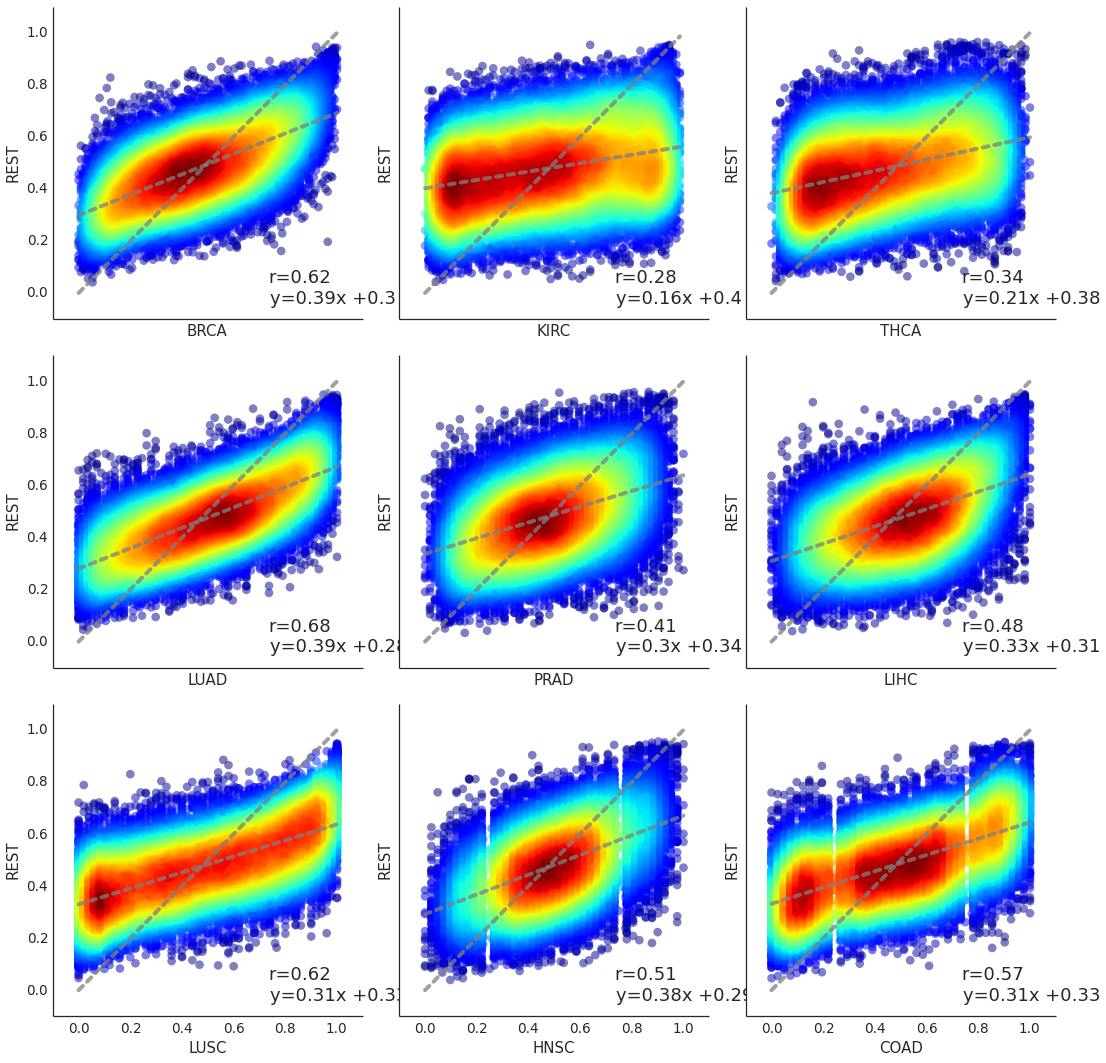

In [13]:
fig, axs = subplots(3,3, figsize=(15,15), sharex=True, sharey=True)
axs = axs.flatten()
for i,c in enumerate(cancers):
    ax = axs[i]
    s1, s2 = match_series(t_h[c].dropna(), t_m[c].dropna())
    fig, ax = init_ax(ax, figsize=(5, 5))
    plot_regression(s1, s2, density=True, rad=.1, ax=ax)

    ax.set_xlabel(c)
    ax.set_ylabel('REST');
sns.despine(fig)
fig.tight_layout()

In [14]:
dx_rna_f = binomial_test_screen(rna_df.ix[:, ti(codes.isin(['BRCA','LUAD','LUSC','HNSC',
                                                            'LIHC','COAD']))], 1.)

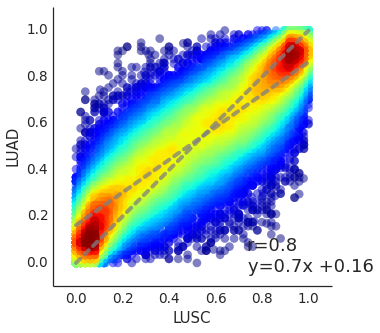

In [15]:
plot_regression(t_h.LUSC.dropna(), t_h.LUAD.dropna(), density=True, rad=.1)

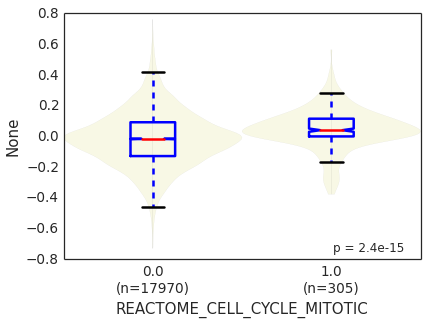

In [16]:
violin_plot_pandas(gs2['REACTOME_CELL_CYCLE_MITOTIC'], (t_h.LUSC - t_h.LUAD).dropna())

In [17]:
rr = screen_feature(t_h.LUSC - t_h.LUAD, rev_kruskal, gs2.T, align=False)
rr.head()

,H,p,q
REACTOME_CELL_CYCLE_MITOTIC,58.00,2.62e-14,2.18e-11
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,50.14,1.43e-12,5.95e-10
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,43.59,4.06e-11,1.03e-08
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,43.19,4.96e-11,1.03e-08
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,39.57,3.17e-10,5.28e-08


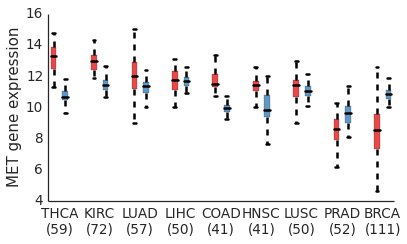

In [18]:
fig, ax = subplots(1,1, figsize=(5.5,4))
paired_bp_tn_split(matched_rna.ix['MET'], codes[codes.isin(cancers)], ax=ax)
fig.savefig('/cellar/users/agross/figures/fig_c.pdf')

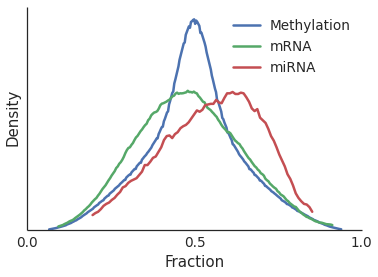

In [19]:
fig, ax = subplots(1,1, figsize=(6,4))
fig_1e(ax)
fig.savefig('/cellar/users/agross/figures/fig_a.pdf')

In [20]:
t_h.BRCA.dropna().shape

(18410,)

In [24]:
plt.rcParams['savefig.dpi'] = 150

In [34]:
ax.get_children()[2].set_visable(False)

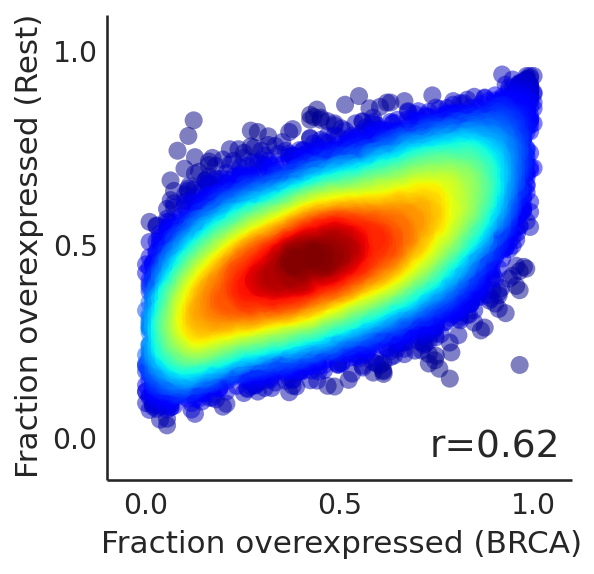

In [36]:
fig, ax = subplots(1,1, figsize=(4,4))
plot_regression(t_h.BRCA.dropna(), t_m.BRCA.dropna(), density=True, rad=.1, ax=ax,
               rasterized=True)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_xticks([0, .5, 1])
ax.set_yticks([0, .5, 1])
ax.get_children()[2].set_visible(False)
ax.get_children()[3].set_visible(False)
ax.set_xlabel('Fraction overexpressed (BRCA)')
ax.set_ylabel('Fraction overexpressed (Rest)')
fig.savefig('/cellar/users/agross/figures/fig_b.pdf')

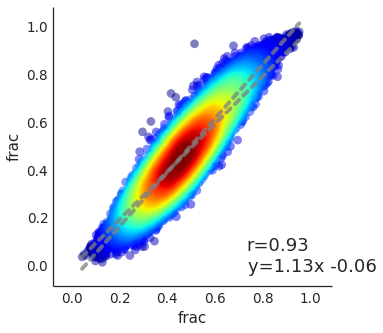

In [19]:
plot_regression(dx_rna.frac, dx_rna_f.frac, density=True, rad=.1)

In [20]:
rr = screen_feature(dx_rna_f.frac - dx_rna.frac, rev_kruskal, gs2.T, align=False)
rr.head()

,H,p,q
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,131.72,1.72e-30,1.43e-27
REACTOME_PEPTIDE_CHAIN_ELONGATION,115.33,6.66e-27,2.77e-24
KEGG_RIBOSOME,110.24,8.66e-26,2.40e-23
REACTOME_CELL_CYCLE_MITOTIC,107.95,2.76e-25,5.75e-23
REACTOME_VIRAL_MRNA_TRANSLATION,107.46,3.53e-25,5.88e-23


In [21]:
rr = screen_feature(dx_rna_f.frac, rev_kruskal, gs2.T, align=False)
rr.head()

,H,p,q
REACTOME_CELL_CYCLE_MITOTIC,285.94,3.80e-64,3.16e-61
REACTOME_MITOTIC_M_M_G1_PHASES,201.94,7.87e-46,3.28e-43
REACTOME_S_PHASE,156.81,5.63e-36,1.56e-33
REACTOME_CELL_CYCLE_CHECKPOINTS,154.48,1.82e-35,3.78e-33
REACTOME_TRANSCRIPTION,146.80,8.66e-34,1.44e-31


In [403]:
dx['BRCA'].xs('binom', axis=1, level=1).ix['MET'].unstack()

,frac,num_dx,num_ox,p
miss,0.75,539,404,3.73e-32
hit,0.08,111,9,4.26e-21


In [22]:
t_h.ix['MET'].order()

BRCA    0.08
PRAD    0.19
LIHC    0.58
LUSC    0.62
LUAD    0.70
HNSC    0.88
KIRC    0.94
THCA    0.95
COAD    0.95
Name: MET, dtype: float64

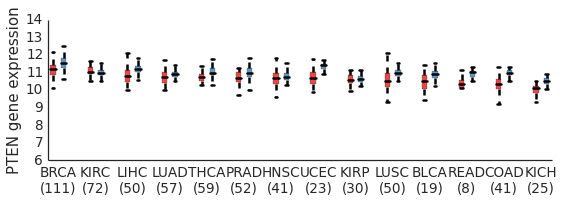

In [28]:
paired_bp_tn_split(matched_rna.ix['PTEN'], codes)

In [29]:
paired_bp_tn_split?

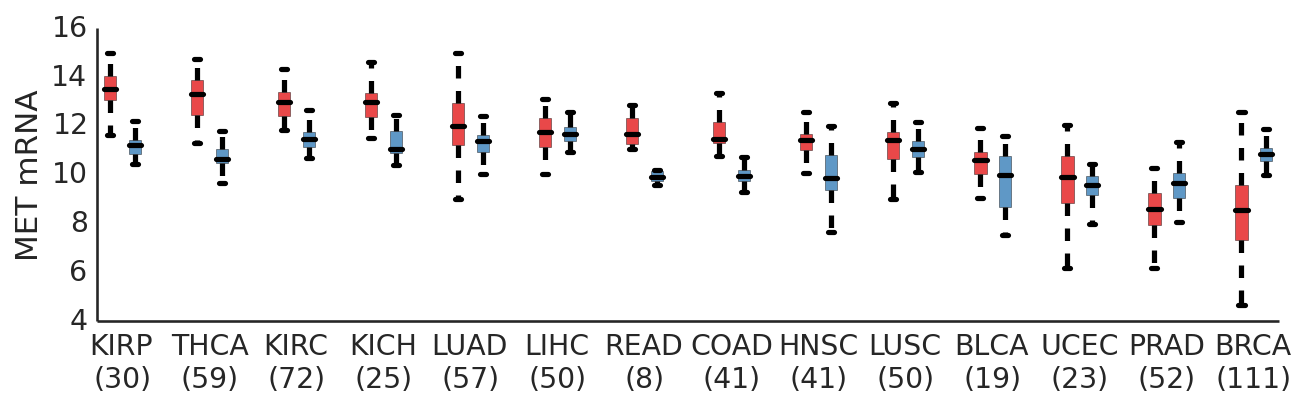

In [38]:
fig, ax = subplots(figsize=(9,3))
paired_bp_tn_split(matched_rna.ix['MET'], codes, ax=ax, data_type='mRNA')
fig.savefig('/cellar/users/agross/figures/met_dx.pdf')

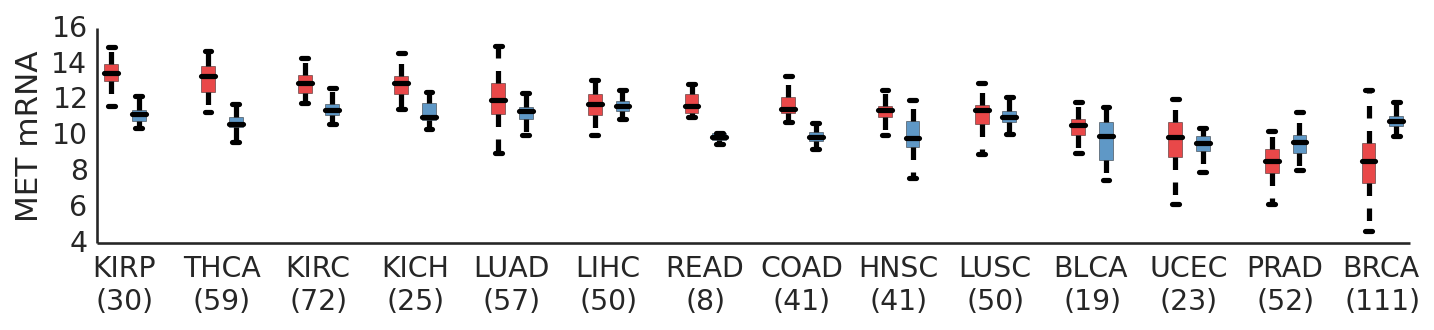

In [30]:
fig, ax = subplots(figsize=(10,2.2))
paired_bp_tn_split(matched_rna.ix['MET'], codes, ax=ax, data_type='mRNA')
#plt.gcf().savefig('/cellar/users/agross/figures/MET.png', dpi=300, tranparent=True)

In [31]:
count = vc.head(9)
count.name = 'count'

reg = pd.DataFrame({c: linear_regression(t_h[c].dropna(), t_m[c]) for c in t_m}).T
reg = reg.join(count)
reg

,intercept,p-value,r-value,slope,stderr,count
BRCA,0.30,0,0.62,0.39,0,111
COAD,0.33,0,0.57,0.31,0,41
HNSC,0.29,0,0.51,0.38,0,41
KIRC,0.40,0,0.28,0.16,0,72
LIHC,0.31,0,0.48,0.33,0,50
LUAD,0.28,0,0.68,0.39,0,57
LUSC,0.33,0,0.62,0.31,0,50
PRAD,0.34,0,0.41,0.30,0,52
THCA,0.38,0,0.34,0.21,0,59


In [33]:
def detrend(x,y):
    x, y = match_series(x, y)
    reg = linear_regression(x, y)
    adj = (y - reg['intercept']) / reg['slope']
    return adj

In [36]:
detrended = {}
for i,c in enumerate(cancers):
    ax = axs[i]
    s1, s2 = match_series(t_h[c].dropna(), t_m[c].dropna())
    s2 = detrend(s1, s2)
    detrended[c] = s1 - s2
detrended = pd.concat(detrended, axis=1)

In [40]:
c = 'BRCA'
adjusted = {}
for c in cancers:
    vec = t_h[c]
    order = t_m[c].order().dropna()
    vec = vec.ix[order.index].dropna()
    mm = pd.rolling_mean(vec, 1000, center=True)
    ss = pd.rolling_std(vec, 1000, center=True)
    zz = ((vec - mm) / ss).dropna()
    reg = linear_regression(order, zz)
    zz = (zz - ((order * reg['slope'])  + reg['intercept'])).dropna()
    adjusted[c] = zz
adjusted = pd.concat(adjusted, axis=1)

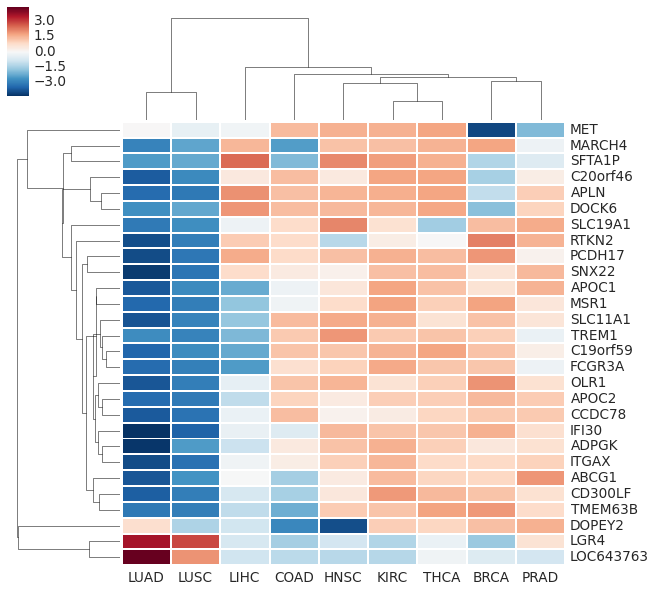

In [420]:
d = adjusted.dropna()
d = d[d.std(1).rank(pct=True) > .998]
sns.clustermap(d)
plt.gcf().savefig('/cellar/users/agross/figures/cancer_cluster2.png', dpi=300)

In [431]:
f = !ls /data/nrnb01_nobackup/agross/TCGA_methylation

In [432]:
sorted([s for s in f if s[:3] != 'jhu'])

['ACC',
 'ACC_R_output.out',
 'ACC_Rscript.r',
 'BLCA',
 'DLBC',
 'ESCA',
 'GBM',
 'READ',
 'THCA',
 'THYM',
 'Try',
 'UCS',
 'UVM_Attempt',
 'move_and_count.sh',
 'nohup.out',
 'quick.sh',
 'short.sh',
 'smallmove.sh',
 'tar_links.txt',
 'url_list.txt']

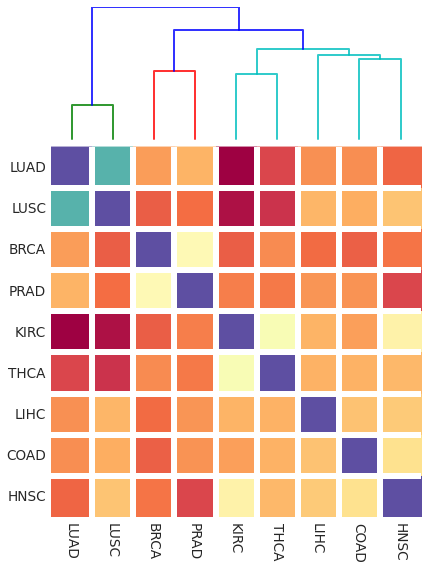

In [413]:
d = adjusted.dropna()
d = d[d.std(1).rank(pct=True) > .9]
fancy_raster(d.corr(), cluster=True)
plt.gcf().tight_layout()
plt.gcf().savefig('/cellar/users/agross/figures/cancer_cluster.png', dpi=300)

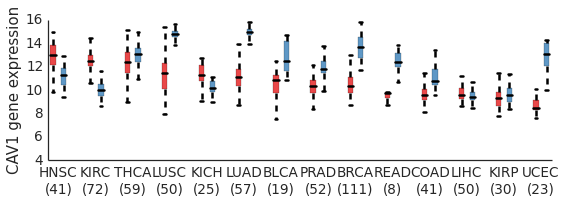

In [56]:
paired_bp_tn_split(matched_rna.ix['CAV1'], codes)

In [57]:
rr = {c: screen_feature(adjusted[c], rev_kruskal, gs2.T, align=False) for 
      c in cancers}
r2 = pd.concat(rr)

In [61]:
d = adjusted.dropna()
pp = gs2.ix[d.index].fillna(0).T.dot(d).div(gs2.sum(), axis=0)

In [63]:
pp = pp[cancers.diff(['KIRC'])]

In [64]:
pd.concat([pp.std(1).order(), gs2.sum()], axis=1).dropna().sort(0).tail(10)

,0,1
REACTOME_TRANSLATION,0.70,119
REACTOME_GTP_HYDROLYSIS_AND_JOINING_OF_THE_60S_RIBOSOMAL_SUBUNIT,0.72,105
REACTOME_FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX,0.73,49
BIOCARTA_ETC_PATHWAY,0.76,11
REACTOME_FORMATION_OF_A_POOL_OF_FREE_40S_SUBUNITS,0.77,94
KEGG_RIBOSOME,0.78,85
REACTOME_VIRAL_MRNA_TRANSLATION,0.80,83
REACTOME_CLASSICAL_ANTIBODY_MEDIATED_COMPLEMENT_ACTIVATION,0.81,5
REACTOME_PEPTIDE_CHAIN_ELONGATION,0.82,83
REACTOME_FORMATION_OF_ATP_BY_CHEMIOSMOTIC_COUPLING,0.92,13


In [65]:
vv = list(ti(gs2['BIOCARTA_ETC_PATHWAY']>0))
o = pp.ix['BIOCARTA_ETC_PATHWAY'].order().index
adjusted.ix[vv].dropna()[o].join(dx_rna.ix[vv][['frac','p']]).sort('frac')

,COAD,HNSC,THCA,LIHC,PRAD,BRCA,LUSC,LUAD,frac,p
SLC25A4,0.25,-0.44,-0.07,-0.07,-1.16,0.04,-0.60,0.24,0.25,7.95e-40
ATP5A1,-1.23,-1.94,-0.70,-0.19,0.10,0.25,2.01,1.15,0.32,2.32e-19
SDHB,-1.62,-0.81,0.27,-1.85,0.39,1.39,1.15,1.09,0.40,1.65e-07
SDHA,-1.46,-0.28,-0.56,-1.59,-0.43,0.39,1.57,1.83,0.48,4.56e-01
UQCRC1,-1.37,-1.99,1.05,-0.51,-0.12,0.90,1.40,0.99,0.50,8.45e-01
NDUFA1,-1.52,-1.17,-0.59,0.76,0.17,1.04,0.50,0.87,0.50,1.00e+00
SDHC,-0.96,-1.07,-1.18,0.44,-0.29,2.34,1.33,1.91,0.52,4.10e-01
SLC25A6,0.92,-1.59,0.37,0.75,1.49,-0.82,0.56,0.13,0.52,2.55e-01
CYCS,-1.75,-0.30,-1.66,0.44,-0.13,1.74,1.07,1.24,0.55,6.76e-03
GPD2,-2.27,-1.05,0.72,0.64,0.59,0.32,0.61,0.69,0.62,2.19e-10


In [66]:
vv = list(ti(gs2['REACTOME_SIGNALING_BY_VEGF']>0))
o = pp.ix['REACTOME_SIGNALING_BY_VEGF'].order().index
adjusted.ix[vv].dropna()[o].join(dx_rna.ix[vv][['frac','p']]).sort('frac')

,PRAD,LUSC,BRCA,LUAD,THCA,LIHC,COAD,HNSC,frac,p
FLT4,-0.29,-1.24,-1.14,-1.28,-0.40,0.16,0.46,1.65,0.32,2.45e-20
KDR,-0.16,-1.20,-0.68,-1.00,0.02,0.27,0.41,0.81,0.35,8.26e-14
VEGFC,-1.00,-0.59,-1.05,-0.51,-0.75,0.49,-0.17,1.27,0.41,4.20e-06
NRP1,0.33,-1.57,-0.88,-0.23,0.58,0.63,-0.56,0.38,0.45,6.76e-03
PDGFC,-1.77,0.50,-1.16,1.00,1.69,-1.74,-0.38,1.33,0.45,1.67e-02
VEGFB,-1.10,-0.89,-0.85,-0.70,-0.56,0.74,0.05,0.80,0.48,4.56e-01
FLT1,0.06,-1.52,-0.86,-1.30,-0.18,1.52,0.53,1.59,0.50,9.69e-01
NRP2,-1.55,-0.70,-0.38,-0.46,1.69,-0.75,-0.53,1.91,0.53,9.16e-02
VEGFA,-0.90,-1.31,0.63,-1.37,-1.20,-0.32,1.54,1.31,0.59,2.87e-06
PGF,-2.15,1.00,-0.88,0.54,-1.53,0.87,0.97,2.06,0.62,2.70e-09


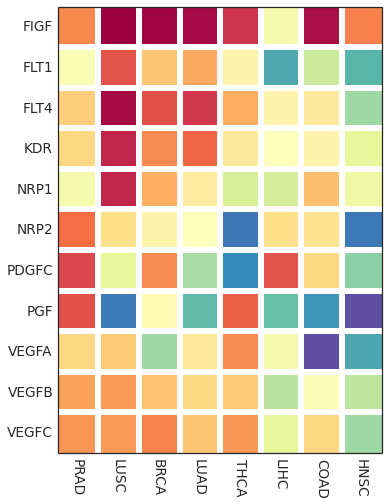

In [67]:
fancy_raster(dx.ix[vv].xs(('hit','binom','frac'), axis=1, level=[1,2,3])[o])

In [68]:
dd = (matched_tn.xs('01',1,1) - matched_tn.xs('11',1,1)).ix[vv]

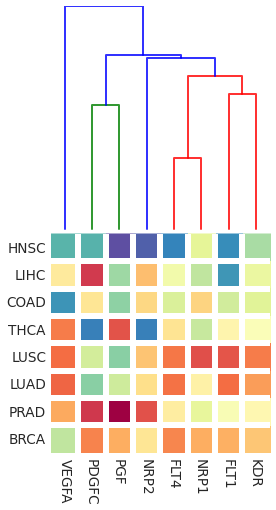

In [69]:
fancy_raster(adjusted.ix[vv].dropna()[o].T, cluster='both')

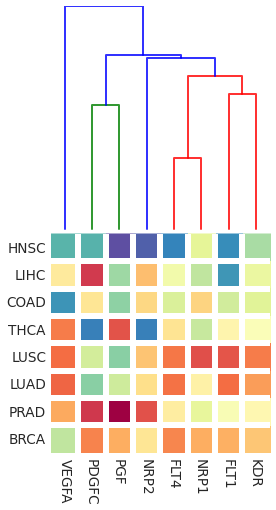

In [70]:
fancy_raster(adjusted.ix[vv].dropna()[o].T, cluster='both')

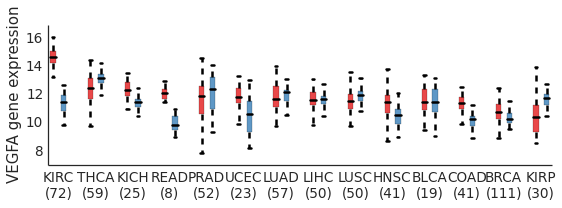

In [71]:
paired_bp_tn_split(matched_rna.ix['VEGFA'], codes)

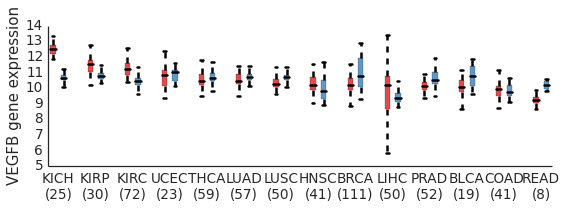

In [72]:
paired_bp_tn_split(matched_rna.ix['VEGFB'], codes)

In [77]:
adjusted.ix[ti(gs2['REACTOME_SIGNALING_BY_VEGF']>0)].mean().order()

PRAD   -0.85
LUSC   -0.75
BRCA   -0.73
LUAD   -0.53
THCA   -0.06
LIHC    0.19
COAD    0.23
HNSC    1.31
KIRC    1.52
dtype: float64

In [78]:
pp.ix['REACTOME_PEPTIDE_CHAIN_ELONGATION'].order()

HNSC   -1.27e+00
BRCA   -1.21e+00
LIHC   -9.35e-02
LUAD   -5.18e-04
LUSC    7.34e-02
THCA    6.94e-01
PRAD    7.28e-01
COAD    8.19e-01
Name: REACTOME_PEPTIDE_CHAIN_ELONGATION, dtype: float64

In [79]:
adjusted.ix[ti(gs2['KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION']>0)].mean().order()

LIHC   -0.63
LUSC   -0.50
PRAD   -0.28
BRCA   -0.22
LUAD   -0.20
COAD   -0.06
HNSC    0.30
THCA    0.32
KIRC    0.77
dtype: float64

In [80]:
r2.xs('REACTOME_TRANSLATION', level=1).sort('p')

,H,p,q
HNSC,147.41,6.39e-34,5.31e-31
BRCA,143.08,5.64e-33,1.56e-30
COAD,102.62,4.06e-24,3.13e-21
KIRC,89.92,2.47e-21,2.57e-19
PRAD,80.00,3.75e-19,3.12e-16
THCA,56.26,6.36e-14,1.32e-11
LUSC,5.05,2.46e-02,8.06e-02
LUAD,1.41,2.36e-01,4.24e-01
LIHC,0.96,3.28e-01,5.31e-01


In [81]:
r2.reset_index(1).groupby(level=0).first()

,level_1,H,p,q
BRCA,REACTOME_PEPTIDE_CHAIN_ELONGATION,148.66,3.40e-34,2.14e-31
COAD,REACTOME_TRANSLATION,102.62,4.06e-24,3.13e-21
HNSC,REACTOME_TRANSLATION,147.41,6.39e-34,5.31e-31
KIRC,REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,152.59,4.72e-35,3.92e-32
LIHC,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,79.86,4.03e-19,3.35e-16
LUAD,REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,64.34,1.05e-15,8.71e-13
LUSC,REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,111.99,3.59e-26,2.99e-23
PRAD,REACTOME_TRANSLATION,80.00,3.75e-19,3.12e-16
THCA,REACTOME_PEPTIDE_CHAIN_ELONGATION,59.13,1.47e-14,6.73e-12


In [82]:
rr = screen_feature(zz, rev_kruskal, gs2.T)
rr.head()

,H,p,q
REACTOME_REGULATION_OF_INSULIN_SECRETION,68.48,1.28e-16,1.07e-13
REACTOME_CELL_CYCLE_MITOTIC,65.83,4.91e-16,2.04e-13
REACTOME_ELECTRON_TRANSPORT_CHAIN,59.81,1.05e-14,2.90e-12
REACTOME_GLUCOSE_REGULATION_OF_INSULIN_SECRETION,56.99,4.39e-14,9.12e-12
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,56.44,5.79e-14,9.63e-12


In [ ]:
pd.DataFrame({c: pearson_pandas(t_h[c].dropna(), t_m[c]) for c in t_m}).T

In [ ]:
pd.DataFrame({c: pearson_pandas(tt[c].dropna(), ttm[c]) for c in t_m}).T

In [ ]:
rr = {c: screen_feature(v[:,c], rev_kruskal, gs2.T, align=False) for 
      c in v.index.get_level_values(1).unique()}
r2 = pd.concat(rr)

In [ ]:
r2.ix['LUSC'].ix['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM']

In [ ]:
def direction(s,p):
    gb = s.groupby(p).mean()
    if len(gb) < 2:
        return False
    return abs(gb[1]) > abs(gb[0])

dd = pd.Series({(c, p): direction(v[:,c],vec) for p,vec in gs2.iteritems()
               for c in v.index.get_level_values(1).unique()})
dd.index = pd.MultiIndex.from_tuples(dd.index)

In [ ]:
r2.ix[dd].sort('p').reset_index(level=1).groupby(level=0).first().sort('p').set_index('level_1', append=True)

In [ ]:
fig, axs = subplots(2,1, figsize=(4,7))
df = matched_rna.ix[ti(gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM']>0)]
f = (df.xs('01', axis=1, level=1) > df.xs('11', axis=1, level=1)).groupby(gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM'])
violin_plot_pandas(codes=='LUSC', f.sum().ix[1] / f.size().ix[1], ax=axs[0])
axs[0].set_xticklabels(['Rest','LUSC'])
axs[0].set_xlabel('Immune Signaling')

df = matched_rna.ix[ti(gs2['REACTOME_PEPTIDE_CHAIN_ELONGATION']>0)]
f = (df.xs('01', axis=1, level=1) > df.xs('11', axis=1, level=1)).groupby(gs2['REACTOME_PEPTIDE_CHAIN_ELONGATION'])
violin_plot_pandas(codes=='KIRC', f.sum().ix[1] / f.size().ix[1], ax=axs[1])
axs[1].set_xticklabels(['Rest','KIRC'])
axs[1].set_xlabel('Peptide Chain Elongation')

for ax in axs:
    ax.set_ylabel('frac')
    prettify_ax(ax)

In [ ]:
vec = dx.BRCA

In [ ]:
rm = vec.miss.binom.frac 
rh = vec.hit.binom.frac
r = ((rm < .75) & (rm > .25)) | ((rh < .75) & (rh > .25))
t = (vec.miss.binom.num_dx > 50) & (vec.hit.binom.num_dx > 20)

gg = ti((vec.hit.binom.frac - vec.miss.binom.frac).dropna() > .3)
gg_up = gg.intersection(ti(r & t))
gg = ti((vec.hit.binom.frac - vec.miss.binom.frac).dropna() < -.3)
gg_down = gg.intersection(ti(r & t))

len(gg_up), len(gg_down)

In [ ]:
v = pd.Series(1, gg_up).ix[ti(t)].fillna(0)
mm = run_mgsa(v==1)
mm.sort('estimate', ascending=False).head()

In [ ]:
v = pd.Series(1, gg_down).ix[ti(t)].fillna(0)
mm = run_mgsa(v==1)
mm.sort('estimate', ascending=False).head()

In [ ]:
ax = None
s1, s2 = lusc_dx.hit.binom.frac, lusc_dx.miss.binom.frac
fig, ax = init_ax(ax, figsize=(5, 5))
ax.hexbin(*match_series(s1,s2), gridsize=80, bins='log', cmap=plt.cm.Greys)
ax.annotate('rho = {0:.2}'.format(Tests.spearman_pandas(s1, s2)['rho']), (.95, .02),
             xycoords='axes fraction', ha='right', va='bottom', size=14)

series_scatter(s1.ix[gg], s2.ix[gg], ax=ax, s=10, alpha=.3,
               color=colors[4], ann=None)

series_scatter(s1.ix[g2], s2.ix[g2], ax=ax, s=10, alpha=1,
               color=colors[0], ann=None)

prettify_ax(ax)
ax.set_ybound(-.05,1.05)
ax.set_xbound(-.05,1.05)
ax.set_xlabel('LUSC')
ax.set_ylabel('REST');

In [ ]:
paired_bp_tn_split(matched_rna.ix['LPCAT1'], codes)

In [ ]:
paired_bp_tn_split(matched_rna.ix['SOX15'], codes)

In [ ]:
violin_plot_series(matched_rna.ix['GUCA1C'].ix[ti(codes=='LUSC')])

In [ ]:
lusc_dx.ix['GUCA1C']

In [ ]:
v = (lusc_dx.hit.binom.frac - lusc_dx.miss.binom.frac)

In [ ]:
rr = screen_feature(v, rev_kruskal, gs2.T, align=False)

In [ ]:
rr.head()

In [ ]:
fig, axs = subplots(1,2, figsize=(8,4), sharey=True)
vec = gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM']
vec.name = 'Immune Signaling'
violin_plot_pandas(vec, lusc_dx.miss.binom.frac,
                  ax=axs[0])
violin_plot_pandas(vec, lusc_dx.hit.binom.frac,
                  ax=axs[1])
fig.tight_layout()

In [ ]:
brca_dx = dx_group(codes == 'KIRC', matched_rna)

In [ ]:
lusc_dx = brca_dx

In [ ]:
gg = ti((lusc_dx.hit.binom.frac - lusc_dx.miss.binom.frac).dropna().abs() > .3)
gg = gg.intersection(ti(lusc_dx.miss.binom.num_dx > 100))

g2 = ti((lusc_dx.hit.binom.frac - lusc_dx.miss.binom.frac).dropna().abs() > .45)
g2 = g2.intersection(ti(lusc_dx.miss.binom.num_dx > 100))
len(gg), len(g2)

In [ ]:
ax = None
s1, s2 = lusc_dx.hit.binom.frac, lusc_dx.miss.binom.frac
fig, ax = init_ax(ax, figsize=(5, 5))
ax.hexbin(*match_series(s1,s2), gridsize=80, bins='log', cmap=plt.cm.Greys)
ax.annotate('rho = {0:.2}'.format(Tests.spearman_pandas(s1, s2)['rho']), (.95, .02),
             xycoords='axes fraction', ha='right', va='bottom', size=14)

series_scatter(s1.ix[gg], s2.ix[gg], ax=ax, s=10, alpha=.3,
               color=colors[4], ann=None)

series_scatter(s1.ix[g2], s2.ix[g2], ax=ax, s=10, alpha=1,
               color=colors[0], ann=None)

prettify_ax(ax)
ax.set_ybound(-.05,1.05)
ax.set_xbound(-.05,1.05)
ax.set_xlabel('LUSC')
ax.set_ylabel('REST');

In [ ]:
v = (lusc_dx.hit.binom.frac - lusc_dx.miss.binom.frac)

In [ ]:
rr = screen_feature(v, rev_kruskal, gs2.T, align=False)

In [ ]:
rr.head()

In [ ]:
vc = codes.ix[matched_rna.columns.get_level_values(0).unique()].value_counts()
vc

In [ ]:
dx = matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)
dx = dx.T.groupby(codes).mean()
dx = dx.ix[vc > 40]

In [607]:
d2 = dx[dx.std(1).rank(pct=True) > .75]

In [ ]:
fancy_raster(d2.corr(), cluster=True)

In [ ]:
d[0]

Index([u'THCA', u'PRAD', u'KIRC', u'HNSC', u'COAD', u'BRCA', u'LIHC', u'LUAD', u'LUSC'], dtype='object')

Index([u'THCA', u'PRAD', u'KIRC', u'LIHC', u'HNSC', u'BRCA', u'COAD', u'LUAD', u'LUSC'], dtype='object')

In [366]:
o

Index([u'THCA', u'PRAD', u'KIRC', u'LIHC', u'HNSC', u'BRCA', u'COAD', u'LUAD', u'LUSC'], dtype='object')

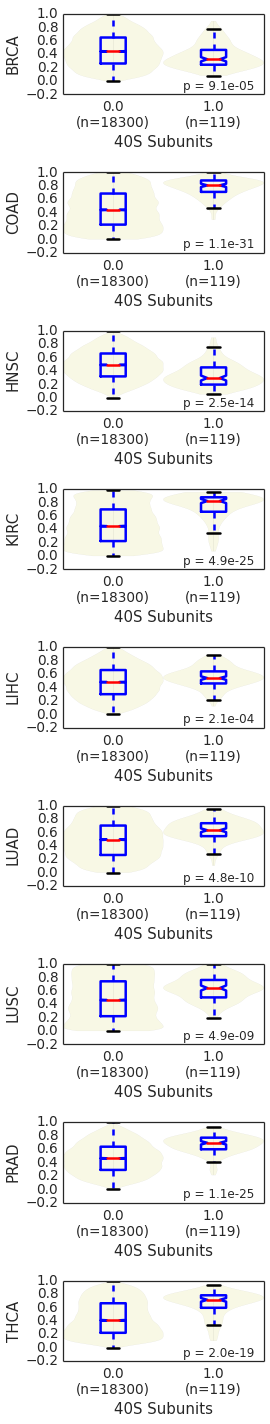

In [590]:
fig, axs = subplots(9,1, figsize=(4,20), sharey=True)
vec = gs2['REACTOME_TRANSLATION']
vec.name = '40S Subunits'
for i,(c,v) in enumerate(dx.iterrows()):
    violin_plot_pandas(vec, v, ax=axs[i])
fig.tight_layout()

In [100]:
dx

,?,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
codes,,,,,,,,,,,,,,,,,,,,,
BRCA,0.37,0.77,0.14,0.25,0.47,0.09,0.45,0.32,0.24,0.05,...,0.29,0.62,0.30,0.76,0.24,0.24,0.13,0.35,0.16,0.11
COAD,0.78,0.17,0.05,0.12,0.59,0.07,0.54,0.29,0.27,0.41,...,0.76,0.78,0.76,0.34,0.05,0.78,0.05,0.68,0.51,0.10
HNSC,0.22,0.54,0.10,0.24,0.39,0.54,0.24,0.56,0.34,0.44,...,0.49,0.49,0.68,0.41,0.17,0.66,0.22,0.63,0.20,0.27
KIRC,0.40,0.56,0.56,0.06,0.18,0.67,0.36,0.74,0.72,0.04,...,0.69,0.47,0.35,0.33,0.22,0.85,0.49,0.29,0.00,0.11
LIHC,0.74,0.12,0.22,0.14,0.36,0.24,0.22,0.78,0.12,0.40,...,0.28,0.42,0.64,0.32,0.26,0.72,0.52,0.52,0.12,0.24
LUAD,0.61,0.56,0.14,0.37,0.79,0.05,0.60,0.44,0.23,0.18,...,0.51,0.46,0.33,0.93,0.30,0.18,0.19,0.81,0.21,0.11
LUSC,0.52,0.42,0.20,0.46,0.66,0.00,0.98,0.72,0.12,0.42,...,0.44,0.40,0.68,0.96,0.14,0.06,0.12,0.86,0.18,0.38
PRAD,0.38,0.12,0.23,0.13,0.81,0.48,0.42,0.21,0.27,0.00,...,0.52,0.67,0.60,0.58,0.21,0.10,0.50,0.67,0.33,0.06
THCA,0.37,0.81,0.12,0.51,0.66,0.58,0.17,0.56,0.44,0.20,...,0.12,0.07,0.22,0.20,0.41,0.69,0.15,0.20,0.24,0.07


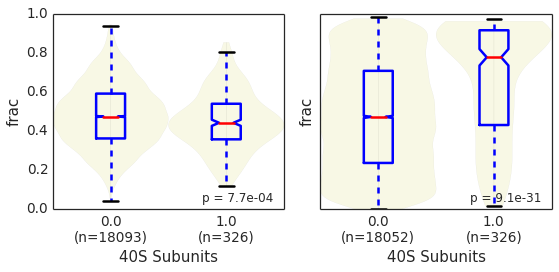

In [88]:
fig, axs = subplots(1,2, figsize=(8,4), sharey=True)

violin_plot_pandas(vec, lusc_dx.miss.binom.frac,
                  ax=axs[0])
violin_plot_pandas(vec, lusc_dx.hit.binom.frac,
                  ax=axs[1])
fig.tight_layout()

In [67]:
v.ix[ti(vec>0)].order()

RPL4     -0.51
EIF3D    -0.50
RPL37    -0.45
RPL6     -0.45
RPLP2    -0.44
RPS7     -0.43
RPL13    -0.43
RPL35A   -0.42
EIF3F    -0.41
RPL9     -0.40
RPL12    -0.40
RPL10    -0.39
RPL5     -0.39
RPL37A   -0.37
RPS4X    -0.37
...
EIF3K     -0.19
FAU       -0.19
RPS29     -0.17
EIF3I     -0.16
EIF3CL    -0.13
EIF1AX    -0.11
RPLP1     -0.10
RPS4Y1    -0.08
RPL28     -0.07
RPS26     -0.07
RPS27      0.00
EIF3C      0.03
EIF3H      0.03
EIF3J      0.16
RPL26L1    0.18
Name: frac, Length: 94, dtype: float64

In [69]:
lusc_dx.ix['RPL4']

miss  binom  num_ox              350
             num_dx              539
             frac              0.649
             p              3.84e-12
      ttest  p              1.67e-11
             t         6.88015370246
hit   binom  num_ox               16
             num_dx              111
             frac              0.144
             p              7.52e-15
      ttest  p              1.01e-15
             t         -9.3838192569
Name: RPL4, dtype: object

In [124]:
dr = (matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)) * 1.
dr = dr.ix[ti(dx_rna.num_dx > 200)].dropna()

In [225]:
odds_ratio = {}
df_odds_ratio = {}
for c in cancers:
    cc = (codes == c).ix[dr.columns]
    odds_ratio[c], df_odds_ratio[c] = odds_ratio_df(dr, cc)
odds_ratio = pd.concat(odds_ratio, 1)
df_odds_ratio = pd.concat(df_odds_ratio, 1)

In [226]:
log_odds = np.log2(odds_ratio).clip(-8,8)

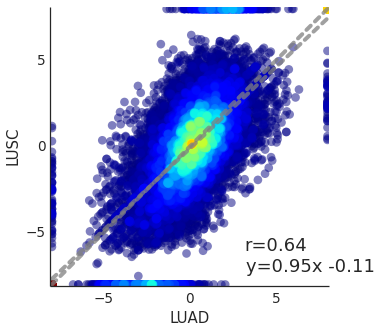

In [227]:
plot_regression(log_odds.LUAD, log_odds.LUSC, density=True, rad=.1)

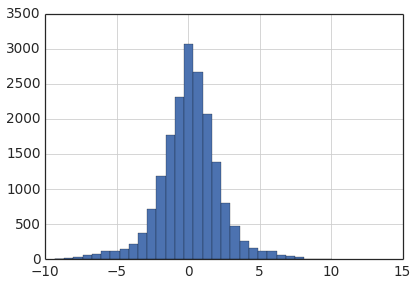

In [232]:
(log_odds.LUAD - log_odds.LUSC).hist(bins=30)

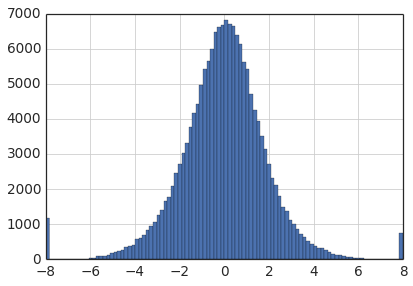

In [235]:
log_odds.stack().hist(bins=100)

In [ ]:
rr = screen_feature(log_odds.ix[k], rev_kruskal, gs2.T > 0)
rr.head()

In [273]:
d2 = df_odds_ratio.unstack().unstack(1)
o2 = log_odds.T.stack()

In [274]:
%time p = d2[o2.abs() > 5].apply(fet, 1).order()

CPU times: user 32.7 s, sys: 0 ns, total: 32.7 s
Wall time: 32.8 s


In [275]:
o2 = o2.ix[o2.index.diff(p[p < .05].index)]

In [281]:
log_odds_f = o2.order().unstack().T

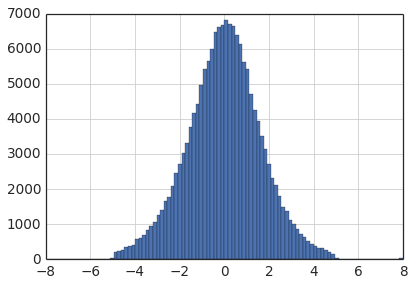

In [276]:
o2.hist(bins=100)

In [512]:
gs3 = gs2.ix[gs2.columns.map(lambda s: s.startswith('KEGG'))]

In [554]:
len(idx)

18419

In [753]:
rr = {}
for p,vec in gs2.iteritems():
    d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
    rr[p] = anova(d['level_1'], d[0])
rr = pd.concat(rr, 1).T

In [758]:
filtered = filter_pathway_hits(rr.p.order(), gs2)

In [802]:
filtered = filtered[filtered < 10e-5]

In [803]:
idx = log_odds_f.index.intersection(gs2.index)
pw = log_odds_f.fillna(0).ix[idx].T.dot(gs2.ix[idx]).T
pw = pw.divide(gs2.ix[idx].sum(), axis=0)
#pw = pw[gs2.ix[idx].sum() > 40]
pw = pw.ix[filtered.index]

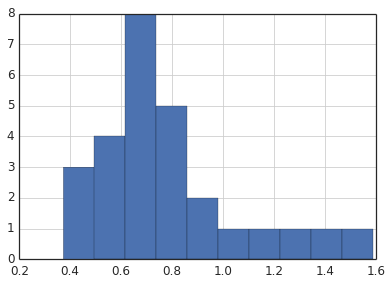

In [804]:
pw.std(1).hist()

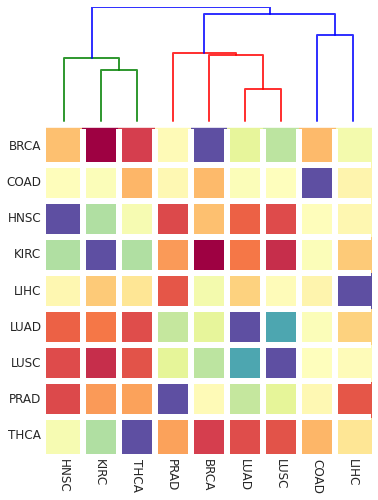

In [805]:
fancy_raster(pw.corr(), cluster=True)

In [806]:
df = pw.ix[filtered.index]
data = df.as_matrix()

In [807]:
n_clusters = (2, 2)
model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(data)
idx = df.index[np.argsort(model.row_labels_)]
col = df.columns[np.argsort(model.column_labels_)]
df_fit = df.ix[idx, col]

In [808]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

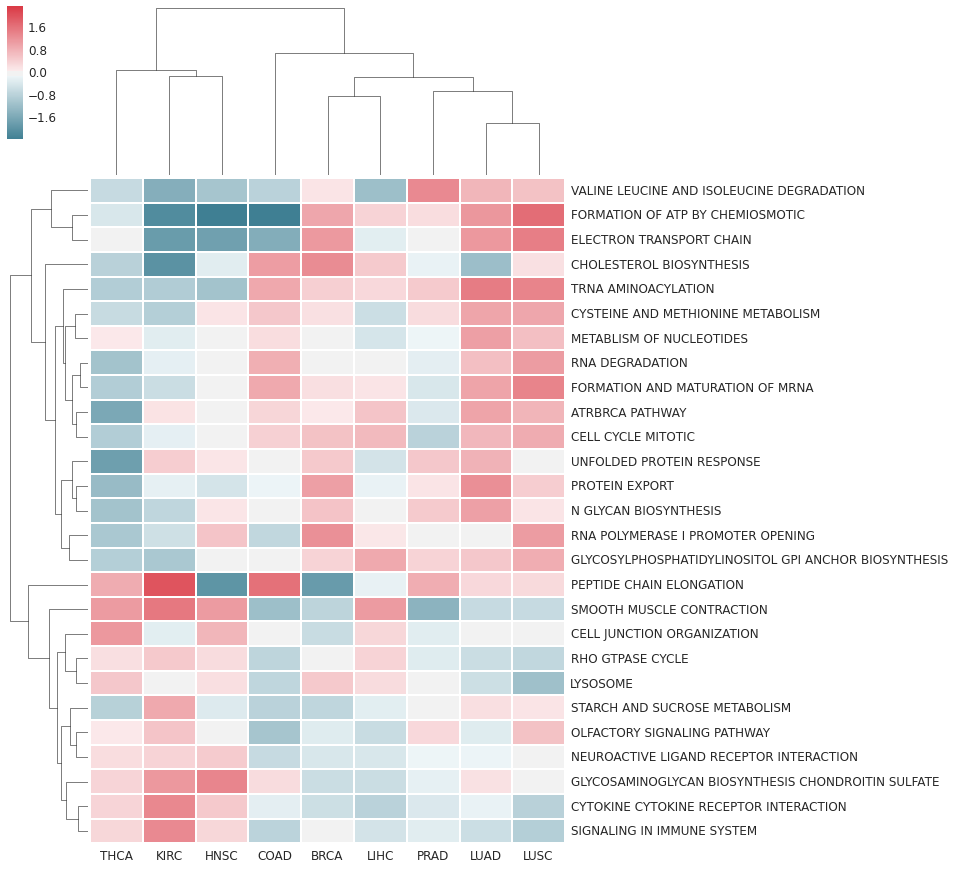

In [809]:
df_fit2 = df_fit.copy()
df_fit2.index = df_fit2.index.map(lambda s: ' '.join(s.split('_')[1:6]))
sns.clustermap(df_fit2, robust=False, cmap=cmap, method='complete',
              figsize=(10,15))

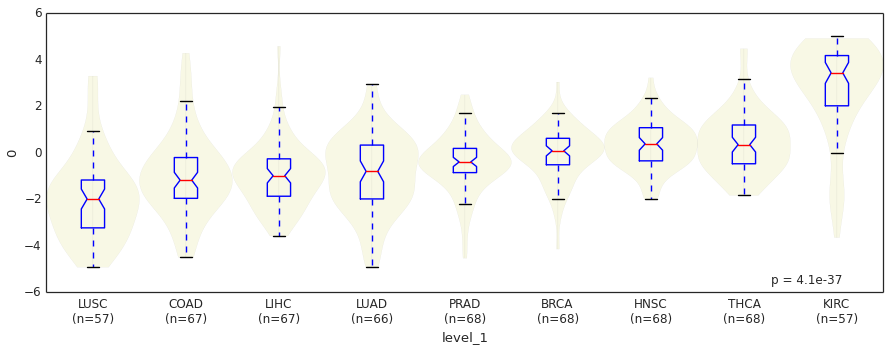

In [717]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

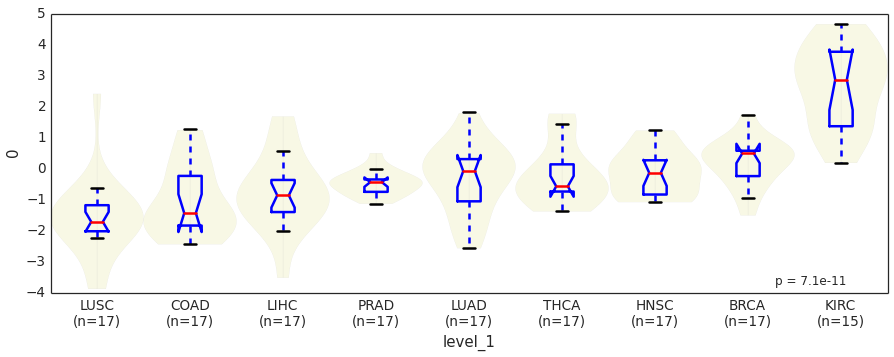

In [433]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['BIOCARTA_NO2IL12_PATHWAY']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

In [215]:
rr = screen_feature(log_odds.ix[k], rev_kruskal, gs2.T > 0)
rr.head()

,H,p,q
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,148.09,4.54e-34,3.77e-31
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,122.42,1.87e-28,7.79e-26
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,97.63,5.05e-23,1.40e-20
KEGG_OXIDATIVE_PHOSPHORYLATION,89.91,2.49e-21,5.17e-19
REACTOME_PEPTIDE_CHAIN_ELONGATION,88.41,5.31e-21,8.84e-19


In [592]:
reload(sns)

<module 'seaborn' from '/cellar/users/agross/anaconda2/lib/python2.7/site-packages/seaborn/__init__.pyc'>

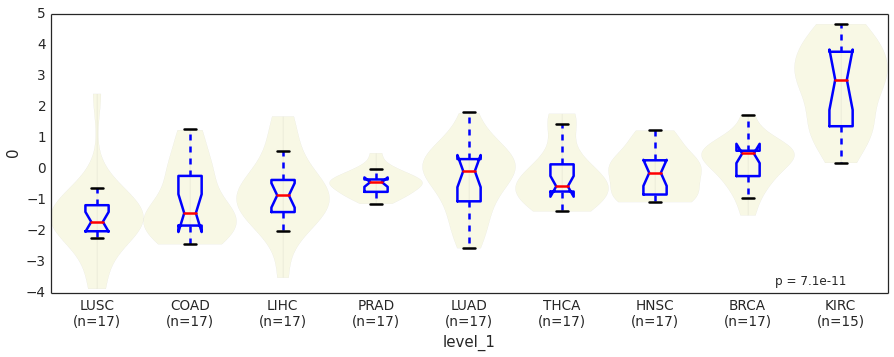

In [368]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['BIOCARTA_NO2IL12_PATHWAY']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

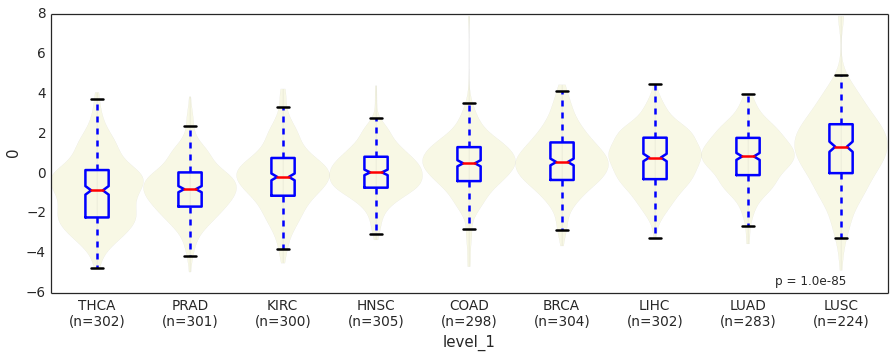

In [369]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_CELL_CYCLE_MITOTIC']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

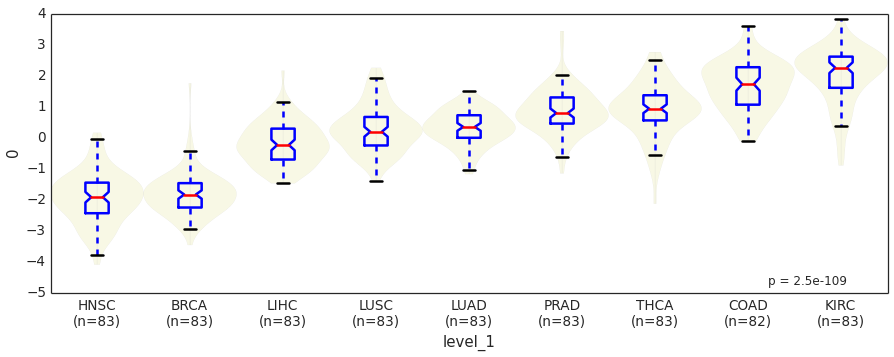

In [386]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_PEPTIDE_CHAIN_ELONGATION']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

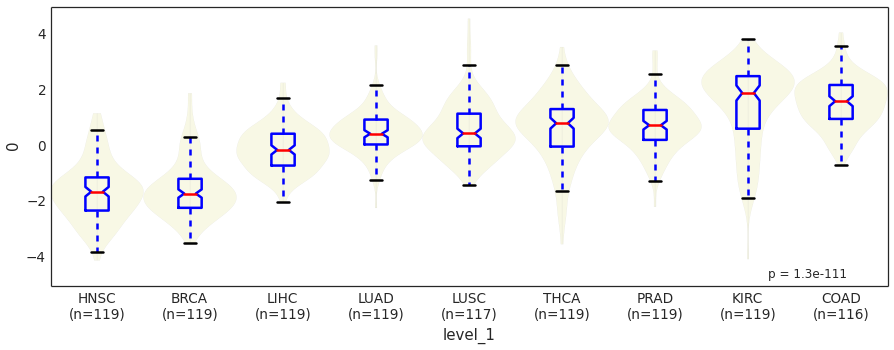

In [389]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_TRANSLATION']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

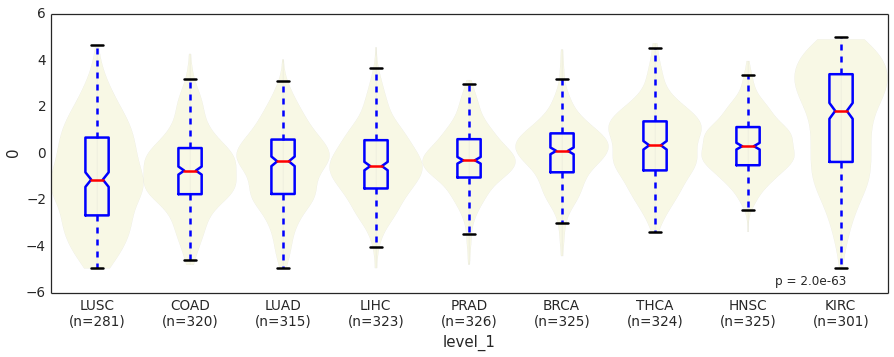

In [387]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)

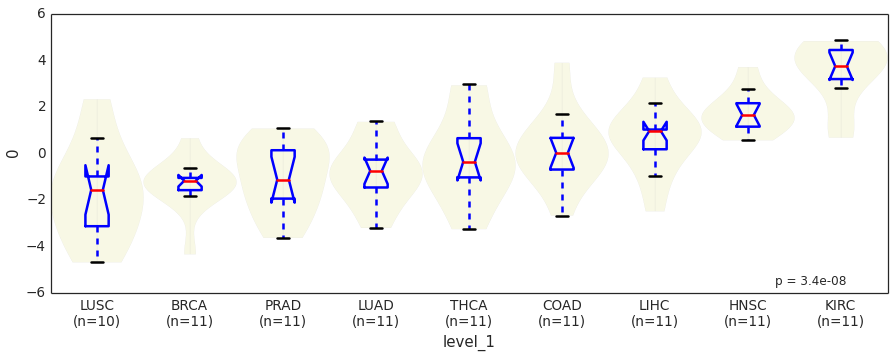

In [388]:
fig, ax = subplots(figsize=(15,5))
vec = gs2['REACTOME_SIGNALING_BY_VEGF']
d = log_odds_f.ix[ti(vec>0)].stack().reset_index(1)
o = d.groupby('level_1').mean()[0].order().index
violin_plot_pandas(d['level_1'], d[0], ax=ax, order=o)